In [70]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [71]:
hist = pd.read_csv("https://raw.githubusercontent.com/ebesier/208finalproject/main/checkpoints_netflix/model_history.csv")
hist.head(15)

,epoch,loss,accuracy,val_loss,val_accuracy,epsilon,delta,best
0,0,2.4636,0.1584,2.4278,0.1665,0.0287,0.0,0
1,1,2.3902,0.1901,2.2648,0.2280,13.4923,0.0,0
2,2,2.3244,0.2154,2.1895,0.2572,15.2527,0.0,0
3,3,2.3060,0.2241,2.1489,0.2817,16.0385,0.0,0
4,4,2.2903,0.2341,2.1070,0.2910,16.4964,0.0,0
5,5,2.2772,0.2399,2.0814,0.3194,16.9543,0.0,0
6,6,2.2593,0.2471,2.0514,0.3149,17.4122,0.0,0
7,7,2.2523,0.2531,2.0173,0.3441,17.8700,0.0,0
8,8,2.2437,0.2572,1.9989,0.3480,18.3279,0.0,0
9,9,2.2355,0.2637,1.9906,0.3628,18.7858,0.0,0


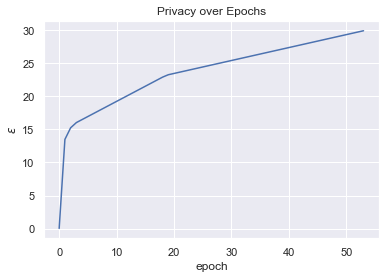

In [72]:
# Plot epsilon growth. Values copied and pasted from model_history.csv. 
sns.set()

x = hist[['epoch']]
y = hist[['epsilon']]

plt.plot(x, y)
plt.xlabel('epoch')
plt.ylabel(r'$\epsilon$')
plt.title('Privacy over Epochs');

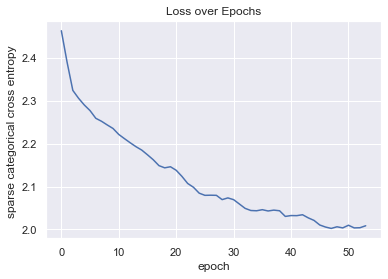

In [73]:
sns.set()

x = hist[['epoch']]
y = hist[['loss']]

plt.plot(x, y)
plt.xlabel('epoch')
plt.ylabel('sparse categorical cross entropy ')
plt.title('Loss over Epochs');

In [75]:
# Read in Netflix data
data_original = pd.read_csv("https://gretel-public-website.s3.amazonaws.com/datasets/netflix/netflix.txt", header = None)

In [97]:
num_samples = int(len(data_original) * .1)

In [98]:
print(num_samples)

2405376


In [99]:
# Sample from original data

data_original = data_original.sample(n=num_samples, random_state=1)

In [100]:
# Read in synthetic data

data_synthetic = pd.read_csv("https://raw.githubusercontent.com/ebesier/208finalproject/main/syn_data_netflix.txt", header = None)

In [101]:
data_original.columns = ['user id', 'movie id', 'rating', 'date']

In [102]:
data_synthetic.columns = ['user id', 'movie id', 'rating', 'date']

In [103]:
data_original.head()

,user id,movie id,rating,date
1523677,312,898603,4,2004-07-19
17329556,3333,530619,4,2005-05-04
6782598,1318,1628484,3,2004-01-07
5263837,1073,2268573,2,2005-06-21
8561654,1707,41468,3,2004-09-27


In [104]:
data_synthetic.head()

,user id,movie id,rating,date
0,38,227456,2,2005-03-18
1,5,50,5,2007-06-27
2,21926342918161,24,4,2004-03-11
3,11,2845283,4,2005-09-23
4,50,178619919,2,2005-09-18


In [105]:
# Some preliminary cleaning 

data_synthetic['rating'] = np.where(data_synthetic['rating'] > 5, 5, data_synthetic['rating'])
data_synthetic['rating'] = np.where(data_synthetic['rating'] < 1, 1, data_synthetic['rating'])
data_synthetic['movie id'] = np.where(data_synthetic['movie id'] < 0, 0, data_synthetic['movie id'])

### Queries

Here we compare various queries: average and median. We'll perform bootstrapping of the original dataset to get an estimate of the true population statistic. 

In [106]:
# Compare average, median rating

means = []
medians = []

num_samples = 5000

for i in range(1000):
    
    bootstrap = np.random.choice(data_original.iloc[:, 2], num_samples, replace = True)
    mean = np.mean(bootstrap)
    means.append(mean)
    median = np.median(bootstrap)
    medians.append(median)
    
print('Population average rating:', np.mean(means))
print('Variance:', np.var(means))

print('Synthetic average rating:', np.mean(data_synthetic.iloc[:, 2]))
print()
print('Population median rating:', np.mean(medians))
print('Variance:', np.var(medians))
print('Synthetic median rating:', np.median(data_synthetic.iloc[:, 2]))

Population average rating: 3.5997301999999998
Variance: 0.00023673852795999992
Synthetic average rating: 3.399359743897559

Population median rating: 4.0
Variance: 0.0
Synthetic median rating: 4.0


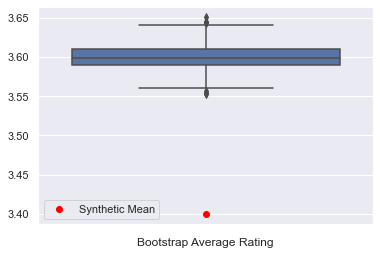

In [107]:
ax = sns.boxplot(data=np.array(means))
ax.set(xticklabels=[])
ax.scatter([0], [np.mean(data_synthetic.iloc[:, 2])], color = 'red', label = 'Synthetic Mean')
plt.legend()
ax.set_xlabel('Bootstrap Average Rating');

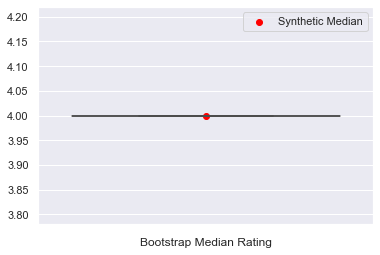

In [108]:
ax = sns.boxplot(data=np.array(medians))
ax.set(xticklabels=[])
ax.scatter([0], [np.median(data_synthetic.iloc[:, 2])], color = 'red', label = 'Synthetic Median')
plt.legend();
ax.set_xlabel('Bootstrap Median Rating');

### Total Variation Distance

We're measuring total variation distance of **rating** because our variable is categorical. 

In [109]:
tvds = []
num_samples = len(data_synthetic.iloc[:, 2])

for i in range(1000):
    bootstrap = np.random.choice(data_original.iloc[:, 2], num_samples, replace = True)
    unique, counts = np.unique(bootstrap, return_counts=True)
    probs_orig = counts/len(bootstrap)
    
    unique, synt_counts = np.unique(data_synthetic.iloc[:, 2], return_counts=True)
    probs_syn = synt_counts/len(data_synthetic)
    
    tvd = 0.5 * sum(abs(probs_orig - probs_syn))
    tvds.append(tvd)

In [110]:
print('Average total variation distance: ', np.mean(tvds))

Average total variation distance:  0.2096236494597839


### Covariance of Variables

We'll check that the correlation between **movie id** and **rating** is still statistically significant.

In [111]:
from scipy.stats import chi2_contingency

In [112]:
v_scores = []

for i in range(1000):
    data = data_original.iloc[:, [1, 2]].sample(n=num_samples).to_numpy()
    X2 = chi2_contingency(data, correction = False)[0]
    n = np.sum(data)
    minDim = min(data.shape)-1

    # Calculate Cramer's V 
    
    V = np.sqrt((X2/n) / minDim)
    v_scores.append(V)

In [113]:
# Display Cramer's V

np.mean(v_scores)

0.003864355164814713

In [114]:
data = data_synthetic.iloc[:, [1, 2]].to_numpy()
X2 = chi2_contingency(data, correction = False)[0]
n = np.sum(data)
minDim = min(data.shape)-1

# Calculate Cramer's V 
V = np.sqrt((X2/n) / minDim)

# Display Cramer's V
print(V)

0.34029041259517184


### Point Estimates

What's the probability of receiving a certain review? Here, we compare point estimates of the two distributions. 

In [115]:
# Probability of receiving each rating 

prob_arr = []

num_samples = len(data_synthetic.iloc[:, 2])

for i in range(1000):
    
    bootstrap = np.random.choice(data_original.iloc[:, 2], num_samples, replace = True)
    unique, counts = np.unique(bootstrap, return_counts=True)
    prob_arr.append(counts/num_samples)

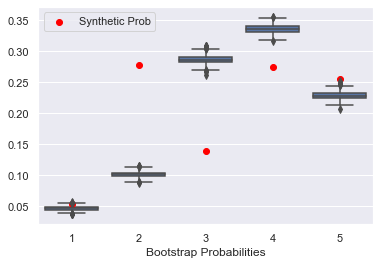

In [116]:
ax = sns.boxplot(data=np.array(prob_arr), color = 'b')
ax.set(xticklabels=[1, 2, 3, 4, 5])
unique, synt_counts = np.unique(data_synthetic.iloc[:, 2], return_counts=True)
ax.scatter([0, 1, 2, 3, 4], synt_counts/len(data_synthetic), color = 'red', label = 'Synthetic Prob')
plt.legend();
ax.set_xlabel('Bootstrap Probabilities');